## The MNIST dataset in Python 
### Goal: to write an algorithm that will detect which digit is written

MNIST stands for Modified National Institute of Standards and Technology database. It consists of 70.000 handwritten digits from 0-9, each represented as a 28x28 grayscale image (all data has the same, fixed size). 

Function: It is commonly used as a benchmark for evaluating machinge learning algorithms, particularly for image classification problems. 


### Import the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist 
# import tensorflow_datasets as tfds
# mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)
# mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

### Set random seeds for reproducibility

To fix the variability issue and ensure reproducibility in the code, I set the random seed values for NumPy, TensorFlow, and Python's built-in random module. Setting the random seeds will ensure that the random processes involved in weight initialization, shuffling, and optimization are performed with the same sequence of random numbers each time the code is run.

This variability can be attributed to the following factors:

**Random Initialization**: The neural network model we're using has weights that are randomly initialized before training. The initial weights can affect the learning process and the final performance of the model.

**Shuffling and Validation Split**: We shuffle the training data and split it into training and validation sets. 
    
**Stochastic Optimization**: The optimization algorithm used during training (Adam), is a stochastic algorithm. It involves randomness in the calculation of gradients and weight updates. Although the randomness is controlled, it can still introduce variations in the training process.


In [2]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### Load and preprocess the data

The MNIST dataset is available in the Tensorflow library. Let's load it and divide it into a training set and a test set with corresponding labels.

Input: train_image

Target: train_labels

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:
#train_images[0]
print(type(train_images))
print(len(train_images))

<class 'numpy.ndarray'>
60000


In [5]:
print(train_images.shape)  # train_images is a 3D NumPy array of shape: (60000, 28, 28) -> 60000 observations, width, height = 28 
print(train_labels.shape)  # 1D NumPy array containing the corresponding labels 0-9 for each training image-> (60000,)
print(test_images.shape)   # (10000, 28, 28)
print(test_labels.shape)   # (10000,)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Let's visualize it

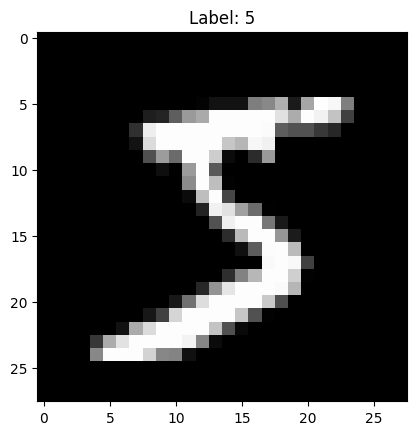

In [6]:
plt.imshow(train_images[0], cmap='gray')
plt.title('Label: ' + str(train_labels[0]))
plt.show()

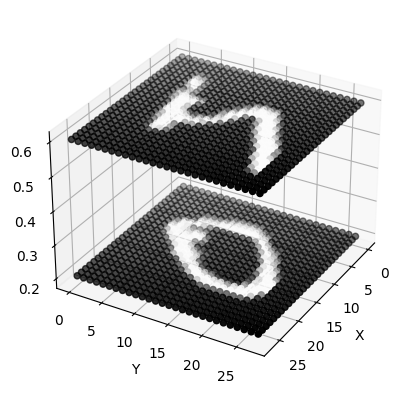

In [7]:
from mpl_toolkits.mplot3d import Axes3D

# 'z' values for the planes
z_values = [0.2, 0.6]

# Creating an empty 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Rotating the figure by 30 degrees (x-axis) and 45 degrees (y-axis)
ax.view_init(30,30)

# Adding planes at different heights
i=1
for z_val in z_values:
    # Creating a grid of points for x,y,z coordinates
    x, y, z = np.meshgrid(range(28), range(28), [z_val])
    
    # Reversing the 'x' plane (mirror reflection)
    x=27-x
    
    # Displaying the plane
    ax.scatter(x.flatten(), y.flatten(), z.flatten(), c=train_images[i], cmap='gray')
    i -= 1

# Setting axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Displaying the plot
plt.show()

### Shuffle data

In [8]:
# array2[array1,] means indexing elements from array2 by values from array1 
# array1 = [2,1,5,3,0,4]
# array2 = [10,20,30,40,50,60]
# array2[array1,] = [30,20,60,40,10,50] -> so first will be element with index 2 from array 2 then with index 1,5 etc. 

In [9]:
n_train = len(train_images)
ind_list_train = [i for i in range(n_train)]
random.shuffle(ind_list_train)
train_images = train_images[ind_list_train,]
train_labels = train_labels[ind_list_train,]

#### Check if everything works correctly

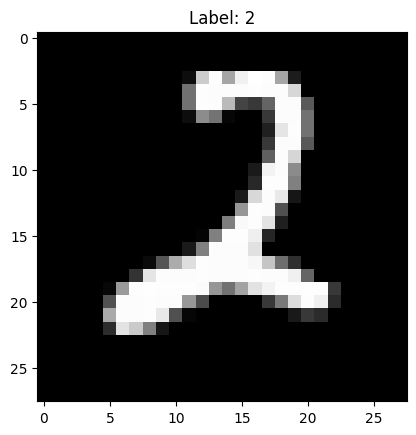

In [10]:
plt.imshow(train_images[50000], cmap='gray')
plt.title('Label: ' + str(train_labels[50000]))
plt.show()

### Training,Validation and Test sets

By default TF splits dataset into training and testing set, however we want also validation set. In our case we would take 10% of training set, so 6000 observations. In this example validation size is integer, however it may not be! Floats can be problematic along the way, so we have to change the type of the output to integer too. 

In [11]:
# rounding to the nearest integer
validation_size = round(0.1 * n_train)
validation_size

6000

In [12]:
validation_images = train_images[:validation_size]
validation_labels = train_labels[:validation_size]
train_images = train_images[validation_size:]
train_labels = train_labels[validation_size:]
print(f"Training set contains: {len(train_images)} observations, while validation set: {len(validation_images)}")

Training set contains: 54000 observations, while validation set: 6000


### Scaling the data

Right now we have values 0-255, but we want them between 0 and 1. 

Firstly, I wanted to write train_images /= 255.0 etc. but I got an error: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'. That was because the operation '/=' requires the result to be of the same data type as the original variable.The MNIST dataset images are originally of type uint8, but when dividing by 255.0 to scale the pixel values, the result becomes a floating-point number of type float64. Moreover,the correct data type to use for images in this case is float32, as it is sufficient to represent the normalized pixel values ranging from 0.0 to 1.0.

I might have written instead: train_images = train_images / 255.0 with no error message and with the same result. 

The labels, on the other hand, are of type uint8 and should not be changed.

In [13]:
train_images = train_images / 255.0
validation_images =  validation_images / 255.0
test_images = test_images / 255.0

### Model

In [14]:
input_size=784
output_size=10
hidden_layer_size = 500 #it is chosen by us 

In [15]:
# we will build a neural network with 2 hidden layers. 
# Sequential() - it is a part where we stack layers
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28,1)), # we flat inputs to a vector
    #tf.keras.layers.Dense(output_size) -> takes the inputs and calculates the dot product of the inputs and weights + add the bias. Here we can also apply an activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size,activation='softmax')
])

### Optimizer and the loss function

In [16]:
# accuracy every iteration 
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# we may try to experiment with different values of learning rate
# custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(optimizer=custom_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training

In [17]:
NUM_EPOCHS = 5
#BATCH_SIZE = 100
#using batching we update weights many times (after each batch) inside a single epoch not just once per epoch 
# we fit the model
# validation_data in a format: (inputs,targets)
#model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(validation_images, validation_labels), verbose =2)
model.fit(train_images, train_labels,epochs=NUM_EPOCHS, validation_data=(validation_images, validation_labels), verbose =2)

Epoch 1/5
1688/1688 - 32s - loss: 0.1913 - accuracy: 0.9425 - val_loss: 0.1170 - val_accuracy: 0.9618 - 32s/epoch - 19ms/step
Epoch 2/5
1688/1688 - 31s - loss: 0.0819 - accuracy: 0.9749 - val_loss: 0.0945 - val_accuracy: 0.9732 - 31s/epoch - 18ms/step
Epoch 3/5
1688/1688 - 32s - loss: 0.0578 - accuracy: 0.9825 - val_loss: 0.0969 - val_accuracy: 0.9695 - 32s/epoch - 19ms/step
Epoch 4/5
1688/1688 - 31s - loss: 0.0442 - accuracy: 0.9865 - val_loss: 0.0859 - val_accuracy: 0.9738 - 31s/epoch - 18ms/step
Epoch 5/5
1688/1688 - 32s - loss: 0.0353 - accuracy: 0.9886 - val_loss: 0.0962 - val_accuracy: 0.9750 - 32s/epoch - 19ms/step


### Testing the model

In [18]:
test_loss, test_accuracy = model.evaluate(test_images,test_labels)

313/313 [==============================] - 2s 7ms/step - loss: 0.0868 - accuracy: 0.9769


In [19]:
#print(f'Test loss: {test_loss}. Test accuracy: {test_accuracy * 100}%')
test_loss = "{:.4f}".format(test_loss)
test_accuracy = "{:.4f}".format(test_accuracy)
print("Test loss: " + test_loss + "." + "Test accuracy: " + test_accuracy + ".")

Test loss: 0.0868.Test accuracy: 0.9769.


## RESULTS

Overall result is satisfying but I'm sure we can make it even better. I will: 

    1) fiddle with the hidden layer size (width)
    
    2) add another hidden layer (depth)
    
    3) try different activation functions 
    
    4) adjust the batch size 
   
Good idea is also to combine these methods above. 

### The hidden layer size 

**hidden_layer_size = 200**
Test loss: 0.0949.Test accuracy: 0.9709.
Duration of one epoch: 8-11s

**hidden_layer_size=500**
Test loss: 0.0868.Test accuracy: 0.9769.
Duration of one epoch: 34-42s

Insights: 

-> The wider hidden layer (the more units in the layer), the higher validation accuracy. 

-> It takes the algorithm much more time to solve the problem

### The number of hidden layers

I added one new layer (tf.keras.layers.Dense(hidden_layer_size, activation='relu')): 
    
Test loss: 0.1224.Test accuracy: 0.9621. 
The accuracy is slightly higher but not significantly. The model has been improved just by 0.0001

    
    

### Wider and deeper net

I was also curious what would be the accuracy when we combine both width and depth of the hidden layer. The model with 3 hidden layers and their size of 200 gives the following results:

Test loss: 0.1046.Test accuracy: 0.9694.

So adding a new layer decreases the accuracy of the model. 

### Activation functions

1. I changed relu activation and I replaced it by tanh:
    
tf.keras.layers.Dense(hidden_layer_size, activation='relu'),

tf.keras.layers.Dense(hidden_layer_size, activation='tanh'),

Test loss: 0.1062.Test accuracy: 0.9678.

2.  

tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'),

tf.keras.layers.Dense(hidden_layer_size, activation='sigmoid'),

Relu cleans the noise in the data 

Test loss: 0.1203.Test accuracy: 0.9627.
        

### Batch size

We don't have to specify the batch size in 'model.fit()'. If we don't do this, it will default to 32.  This means that during each training epoch, the model will process the training data in mini-batches of size 32. Initially, I did not fiddle with batch size, I skipped it. 

Now I want to check what will happen with the result if I increase the batch size to 100,30000 and 50000. When we're increasing the batch size during training, we're changing the number of samples that are processed together before updating the model's parameters (weights/biases). So for example if I have 60,000 observations and I set a batch size to 10,000 that means that in each epoch I will 6 times update the weights. 

What is more: 

1. **Memory requirements** - The choice of batch size is influenced by computational limitations, such as memory constraints or hardware limitations. Larger batch sizes requires more memory to store activations and gradients during backpropagation. 

2. **Training time** - Smaller batch sizes tend to lead to slower convergence because the model is updated more frequently with noisy gradients from individual examples. In contrast, larger batch sizes can lead to faster convergence since the updates are based on more stable and accurate average gradients (model makes larger updates in each iteration). 

3. **Generalization performance** - Smaller batches introduce more noise and randomness into the training process, which can help the model to avoid overfitting and improve generalization to unseen data. With larger batch sizes, the optimization process can be smoother and potentially result in worse generalization performance. 

<u>Batch size = 1</u>

We have 5400 batches in each epoch, so it takes the algorithm very long time. However, the validation accuracy is initially very  high, then it decreases. 

**Test loss: 0.1616.Test accuracy: 0.9639.**

<br>

<u>Batch size = 100</u>

**Test loss: 0.1179.Test accuracy: 0.9638.**

<br>

<u>Batch size = 30000</u>

Epoch 1/5

2/2 - 2s - loss: 2.3596 - accuracy: 0.1441 - val_loss: 2.2655 - val_accuracy: 0.2050 - 2s/epoch - 1s/step

Epoch 2/5

2/2 - 0s - loss: 2.2460 - accuracy: 0.2206 - val_loss: 2.1782 - val_accuracy: 0.2985 - 403ms/epoch - 201ms/step

Epoch 3/5

2/2 - 0s - loss: 2.1610 - accuracy: 0.3079 - val_loss: 2.1014 - val_accuracy: 0.3732 - 411ms/epoch - 205ms/step

Epoch 4/5

2/2 - 0s - loss: 2.0819 - accuracy: 0.3792 - val_loss: 2.0154 - val_accuracy: 0.4298 - 320ms/epoch - 160ms/step

Epoch 5/5

2/2 - 0s - loss: 1.9928 - accuracy: 0.4449 - val_loss: 1.9161 - val_accuracy: 0.4950 - 337ms/epoch - 168ms/step

Test loss: 1.9009.Test accuracy: 0.5056.

We have to increase the number of epochs. (NUM_EPOCHS=100)

**Test loss: 0.1818.Test accuracy: 0.9489.**

<br>

<u>Batch size = 50000</u>

**Test loss: 0.1915.Test accuracy: 0.9457.**

<div class="alert alert-block alert-warning">
Final observation: The bigger batches, the lower accuracy. Plus we need to increase number of epochs to reach satisfying solution
</div>
 